# Classification OK/Défaut — Fine-tuning ResNet50 + Grad-CAM

Ce notebook entraîne un modèle de classification binaire (OK vs Défaut) en fine-tunant un ResNet50 pré-entraîné,
évalue ses performances (accuracy, precision, recall, F1, matrice de confusion, courbe ROC),
puis génère des heatmaps Grad-CAM pour visualiser les zones de décision du modèle.

In [1]:
import sys
print(f"Python version: {sys.version}")
assert sys.version_info[:2] == (3, 12), f"Expected Python 3.12, got {sys.version_info[:2]}"

# Mêmes versions que le venv / backend
!pip install --no-cache-dir torch==2.9.0+cpu torchvision==0.24.0+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install --no-cache-dir scikit-learn==1.6.1 scipy joblib "numpy<2" Pillow matplotlib

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Looking in indexes: https://download.pytorch.org/whl/cpu

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os, sys, time, copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
from PIL import Image
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from collections import Counter

# --- Configuration ---
CASTING_DATA_DIR = Path('casting_data')
MODELS_DIR = Path('models')
RESNET_WEIGHTS = MODELS_DIR / 'resnet50_extractor.pth'
OUTPUT_MODEL = MODELS_DIR / 'resnet50_classifier.pth'
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Device: {DEVICE}')
print(f'PyTorch: {torch.__version__}')
print(f'Poids existants: {RESNET_WEIGHTS} (exists={RESNET_WEIGHTS.exists()})')

Device: cpu
PyTorch: 2.9.0+cpu
Poids existants: models/resnet50_extractor.pth (exists=True)


## 1. Préparation des données

Le dossier `train/ok_front` est vide — toutes les images OK sont dans `test/ok_front`.
On combine donc toutes les images (train + test) puis on fait un split stratifié 80/20.
Data augmentation légère sur le train, transforms standard sur le test.

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Collecter TOUTES les images (train + test) ---
all_images = []
all_labels = []

for split in ['train', 'test']:
    for label_name, label_idx in [('def_front', 0), ('ok_front', 1)]:
        folder = CASTING_DATA_DIR / split / label_name
        if folder.exists():
            for img_path in sorted(folder.glob('*.jpeg')):
                all_images.append(str(img_path))
                all_labels.append(label_idx)

print(f'Total images collectées: {len(all_images)}')
print(f'  Défaut (0): {all_labels.count(0)}')
print(f'  OK (1):     {all_labels.count(1)}')

# --- Split stratifié 80/20 ---
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f'\nSplit 80/20 stratifié:')
print(f'  Train: {len(train_paths)} images (def={train_labels.count(0)}, ok={train_labels.count(1)})')
print(f'  Test:  {len(test_paths)} images (def={test_labels.count(0)}, ok={test_labels.count(1)})')


class CastingDataset(Dataset):
    """Dataset personnalisé à partir de listes de chemins + labels."""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


train_dataset = CastingDataset(train_paths, train_labels, transform=train_transform)
test_dataset = CastingDataset(test_paths, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

class_names = ['def_front', 'ok_front']  # 0=def, 1=ok
print(f'\nClasses: {class_names}')
print(f'Train: {len(train_dataset)} images')
print(f'Test:  {len(test_dataset)} images')
print(f'Répartition train: {Counter(train_labels)}')
print(f'Répartition test:  {Counter(test_labels)}')

Total images collectées: 914
  Défaut (0): 652
  OK (1):     262

Split 80/20 stratifié:
  Train: 731 images (def=521, ok=210)
  Test:  183 images (def=131, ok=52)

Classes: ['def_front', 'ok_front']
Train: 731 images
Test:  183 images
Répartition train: Counter({0: 521, 1: 210})
Répartition test:  Counter({0: 131, 1: 52})


## 2. Construction du modèle

ResNet50 avec backbone gelé + tête de classification entraînable.

In [5]:
class ResNet50Classifier(nn.Module):
    """ResNet50 avec backbone gelé et tête de classification."""
    
    def __init__(self, num_classes=2, weights_path=None):
        super().__init__()
        
        # Charger ResNet50 de base
        base_model = models.resnet50(weights=None)
        
        # Charger les poids existants si fournis
        if weights_path and os.path.exists(weights_path):
            # Les poids sauvés correspondent au FeatureExtractor (tout sauf fc)
            # On charge ce qu'on peut
            state_dict = torch.load(weights_path, map_location='cpu', weights_only=True)
            # Filtrer les clés pour ne garder que celles qui matchent
            model_dict = base_model.state_dict()
            # Les poids du FeatureExtractor sont sous 'features.X.*'
            # On doit les remapper vers le ResNet50 standard
            mapped_dict = {}
            resnet_children = list(base_model.children())[:-1]  # sans fc
            child_names = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
            
            for key, value in state_dict.items():
                # Format: 'features.0.weight' -> 'conv1.weight'
                if key.startswith('features.'):
                    parts = key.split('.', 2)  # ['features', '0', 'weight...']
                    idx = int(parts[1])
                    if idx < len(child_names):
                        new_key = child_names[idx] + '.' + parts[2] if len(parts) > 2 else child_names[idx]
                        if new_key in model_dict and model_dict[new_key].shape == value.shape:
                            mapped_dict[new_key] = value
            
            base_model.load_state_dict(mapped_dict, strict=False)
            print(f'Poids chargés: {len(mapped_dict)}/{len(model_dict)} paramètres mappés')
        
        # Backbone: tout sauf la couche fc
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
        self.avgpool = base_model.avgpool
        
        # Geler le backbone
        for param in [self.conv1, self.bn1, self.layer1, self.layer2, self.layer3, self.layer4]:
            for p in param.parameters():
                p.requires_grad = False
        
        # Tête de classification (seule partie entraînable)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        # Pour Grad-CAM: hook sur layer4
        self.gradients = None
        self.activations = None
    
    def save_gradient(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Sauvegarder activations pour Grad-CAM
        self.activations = x
        if x.requires_grad:
            x.register_hook(self.save_gradient)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Créer le modèle
model = ResNet50Classifier(num_classes=2, weights_path=str(RESNET_WEIGHTS))
model = model.to(DEVICE)

# Vérifier les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nParamètres totaux:      {total_params:,}')
print(f'Paramètres entraînables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)')

Poids chargés: 318/320 paramètres mappés

Paramètres totaux:      24,033,090
Paramètres entraînables: 525,058 (2.2%)


## 3. Entraînement

In [7]:
# Loss et optimizer (seulement les paramètres entraînables)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Early stopping
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
PATIENCE = 8

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f'Entraînement: {NUM_EPOCHS} epochs max, early stopping patience={PATIENCE}')
print(f'Optimizer: Adam, lr={LEARNING_RATE}')
print(f'Loss: CrossEntropyLoss')
print(f'Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)')
print('=' * 70)

for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    
    # --- Train ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss /= train_total
    train_acc = train_correct / train_total
    
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    # Scheduler
    scheduler.step(val_loss)
    
    # History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    elapsed = time.time() - t0
    marker = ''
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
        marker = ' << BEST'
    else:
        patience_counter += 1
    
    print(f'Epoch {epoch+1:2d}/{NUM_EPOCHS} | '
          f'Train loss={train_loss:.4f} acc={train_acc:.3f} | '
          f'Val loss={val_loss:.4f} acc={val_acc:.3f} | '
          f'{elapsed:.1f}s{marker}')
    
    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch+1} (patience={PATIENCE})')
        break

# Restaurer le meilleur modèle
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f'\nMeilleur modèle restauré (val_loss={best_val_loss:.4f})')

Entraînement: 30 epochs max, early stopping patience=8
Optimizer: Adam, lr=0.001
Loss: CrossEntropyLoss
Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
Epoch  1/30 | Train loss=0.6351 acc=0.685 | Val loss=0.4860 acc=0.716 | 17.9s << BEST
Epoch  2/30 | Train loss=0.5078 acc=0.752 | Val loss=0.4411 acc=0.907 | 17.9s << BEST
Epoch  3/30 | Train loss=0.4389 acc=0.802 | Val loss=0.4460 acc=0.825 | 17.7s
Epoch  4/30 | Train loss=0.3568 acc=0.840 | Val loss=0.5313 acc=0.705 | 17.3s
Epoch  5/30 | Train loss=0.3507 acc=0.847 | Val loss=0.2266 acc=0.945 | 17.4s << BEST
Epoch  6/30 | Train loss=0.2845 acc=0.886 | Val loss=0.2024 acc=0.902 | 17.9s << BEST
Epoch  7/30 | Train loss=0.4070 acc=0.785 | Val loss=0.2262 acc=0.913 | 18.8s
Epoch  8/30 | Train loss=0.3324 acc=0.851 | Val loss=0.2541 acc=0.907 | 17.5s
Epoch  9/30 | Train loss=0.2665 acc=0.889 | Val loss=0.3737 acc=0.820 | 19.2s
Epoch 10/30 | Train loss=0.2727 acc=0.892 | Val loss=0.4806 acc=0.765 | 17.7s
Epoch 11/30 | Train loss=0.256

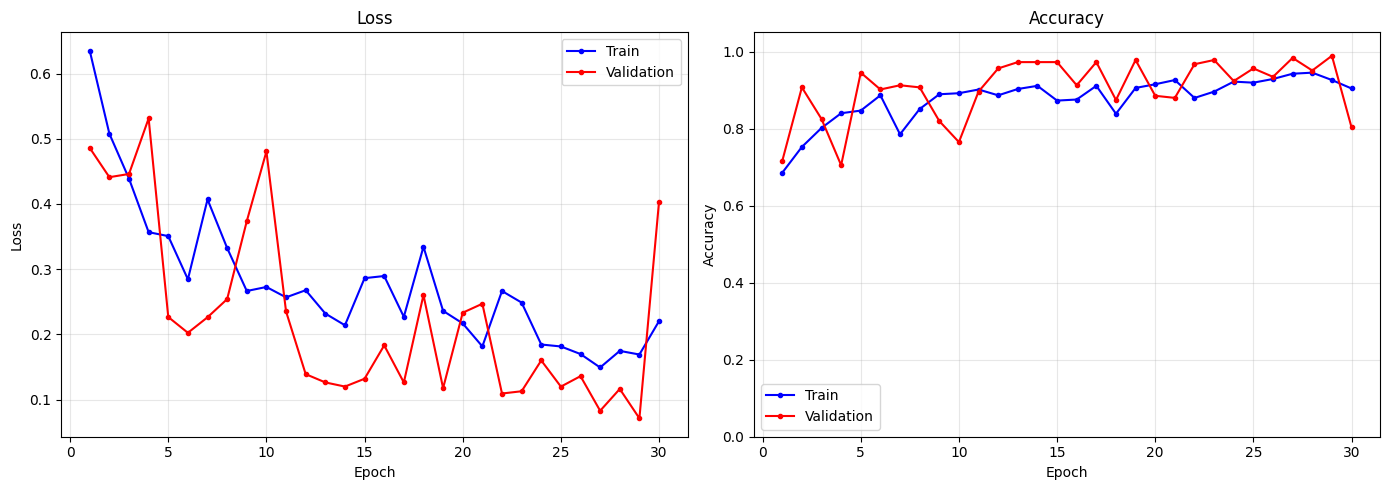

In [8]:
# Courbes d'entraînement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs_range, history['train_loss'], 'b-o', markersize=3, label='Train')
ax1.plot(epochs_range, history['val_loss'], 'r-o', markersize=3, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, history['train_acc'], 'b-o', markersize=3, label='Train')
ax2.plot(epochs_range, history['val_acc'], 'r-o', markersize=3, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## 4. Évaluation complète sur le set de test

In [9]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Prédictions sur tout le test set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# --- Métriques ---
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary', pos_label=0)  # 0=def
rec = recall_score(all_labels, all_preds, average='binary', pos_label=0)
f1 = f1_score(all_labels, all_preds, average='binary', pos_label=0)

print('=' * 50)
print('RÉSULTATS SUR LE SET DE TEST')
print('=' * 50)
print(f'Accuracy:  {acc:.4f} ({acc*100:.1f}%)')
print(f'Precision: {prec:.4f} (pour classe défaut)')
print(f'Recall:    {rec:.4f} (pour classe défaut)')
print(f'F1-score:  {f1:.4f}')
print()
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

RÉSULTATS SUR LE SET DE TEST
Accuracy:  0.9891 (98.9%)
Precision: 0.9924 (pour classe défaut)
Recall:    0.9924 (pour classe défaut)
F1-score:  0.9924

Classification Report:
              precision    recall  f1-score   support

   def_front       0.99      0.99      0.99       131
    ok_front       0.98      0.98      0.98        52

    accuracy                           0.99       183
   macro avg       0.99      0.99      0.99       183
weighted avg       0.99      0.99      0.99       183



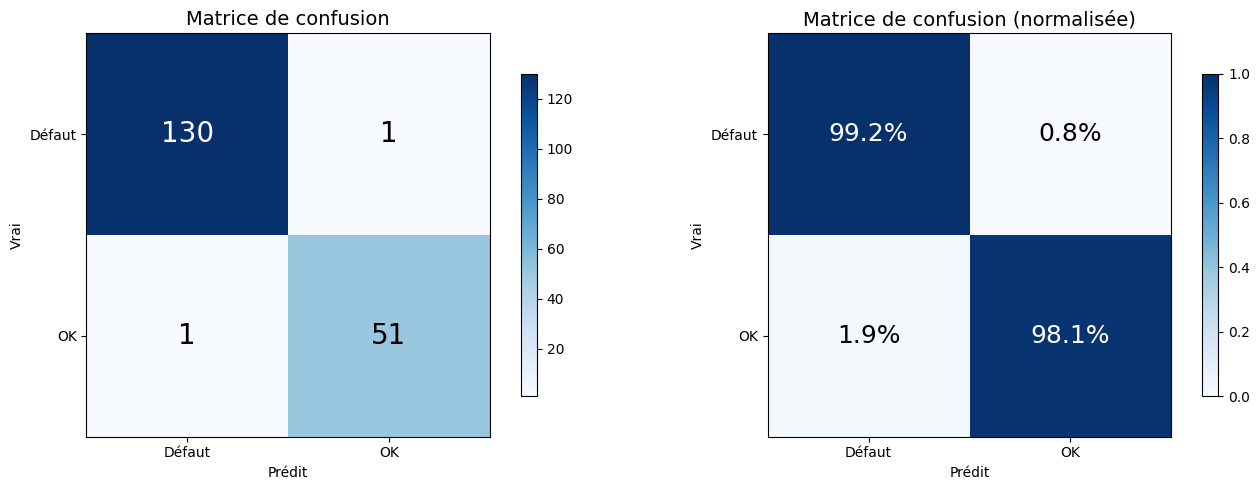

In [10]:
# --- Matrice de confusion ---
cm_matrix = confusion_matrix(all_labels, all_preds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Matrice brute
im = ax1.imshow(cm_matrix, interpolation='nearest', cmap='Blues')
ax1.set_title('Matrice de confusion', fontsize=14)
ax1.set_xlabel('Prédit')
ax1.set_ylabel('Vrai')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Défaut', 'OK'])
ax1.set_yticklabels(['Défaut', 'OK'])
for i in range(2):
    for j in range(2):
        color = 'white' if cm_matrix[i, j] > cm_matrix.max() / 2 else 'black'
        ax1.text(j, i, f'{cm_matrix[i, j]}', ha='center', va='center', fontsize=20, color=color)
fig.colorbar(im, ax=ax1, shrink=0.8)

# Matrice normalisée
cm_norm = cm_matrix.astype(float) / cm_matrix.sum(axis=1, keepdims=True)
im2 = ax2.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
ax2.set_title('Matrice de confusion (normalisée)', fontsize=14)
ax2.set_xlabel('Prédit')
ax2.set_ylabel('Vrai')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Défaut', 'OK'])
ax2.set_yticklabels(['Défaut', 'OK'])
for i in range(2):
    for j in range(2):
        color = 'white' if cm_norm[i, j] > 0.5 else 'black'
        ax2.text(j, i, f'{cm_norm[i, j]:.1%}', ha='center', va='center', fontsize=18, color=color)
fig.colorbar(im2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.show()

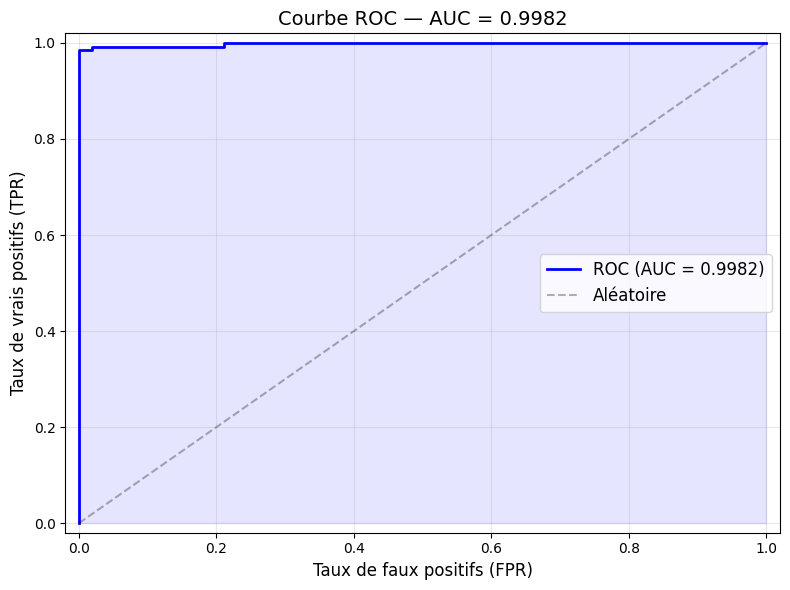

AUC = 0.9982


In [11]:
# --- Courbe ROC ---
# Probabilité de la classe "défaut" (index 0)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 0], pos_label=0)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Aléatoire')
ax.fill_between(fpr, tpr, alpha=0.1, color='blue')
ax.set_xlabel('Taux de faux positifs (FPR)', fontsize=12)
ax.set_ylabel('Taux de vrais positifs (TPR)', fontsize=12)
ax.set_title(f'Courbe ROC — AUC = {roc_auc:.4f}', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
plt.tight_layout()
plt.show()

print(f'AUC = {roc_auc:.4f}')

## 5. Sauvegarde du modèle

In [12]:
# Sauvegarder le modèle complet
torch.save(model.state_dict(), OUTPUT_MODEL)
file_size = OUTPUT_MODEL.stat().st_size / (1024 * 1024)
print(f'Modèle sauvé: {OUTPUT_MODEL} ({file_size:.1f} MB)')
print(f'Accuracy test: {acc:.4f}')
print(f'F1-score test: {f1:.4f}')
print(f'AUC test: {roc_auc:.4f}')

Modèle sauvé: models/resnet50_classifier.pth (92.0 MB)
Accuracy test: 0.9891
F1-score test: 0.9924
AUC test: 0.9982


## 6. Grad-CAM — Heatmaps de décision

Grad-CAM utilise les gradients de la classe prédite par rapport aux activations de `layer4`.
Contrairement à l'approche SVM précédente, ici le modèle est end-to-end : les gradients traversent directement
la tête de classification jusqu'à la couche convolutive, ce qui donne des heatmaps beaucoup plus précises.

In [13]:
def grad_cam(model, img_tensor, target_class=None):
    """
    Calcule la heatmap Grad-CAM pour une image.
    
    Args:
        model: ResNet50Classifier
        img_tensor: (3, 224, 224) tensor normalisé
        target_class: classe cible (None = classe prédite)
    
    Returns:
        heatmap: (224, 224) array normalisé [0,1]
        pred_class: int
        confidence: float
    """
    model.eval()
    img = img_tensor.unsqueeze(0).to(DEVICE)
    img.requires_grad_(True)
    
    # Forward
    output = model(img)
    probs = torch.softmax(output, dim=1)
    pred_class = output.argmax(dim=1).item()
    confidence = probs[0, pred_class].item()
    
    if target_class is None:
        target_class = pred_class
    
    # Backward sur la classe cible
    model.zero_grad()
    output[0, target_class].backward()
    
    # Récupérer gradients et activations de layer4
    gradients = model.gradients  # (1, 2048, 7, 7)
    activations = model.activations  # (1, 2048, 7, 7)
    
    # Poids = moyenne spatiale des gradients par canal
    weights = gradients.mean(dim=[2, 3], keepdim=True)  # (1, 2048, 1, 1)
    
    # Heatmap = ReLU(sum pondérée des activations)
    cam = (weights * activations).sum(dim=1, keepdim=True)  # (1, 1, 7, 7)
    cam = torch.relu(cam)
    
    # Upsample à 224x224
    cam = torch.nn.functional.interpolate(cam, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
    cam = cam.squeeze().detach().cpu().numpy()
    
    # Normaliser [0, 1]
    if cam.max() > 0:
        cam = cam / cam.max()
    
    return cam, pred_class, confidence


def show_gradcam(img_path, model, transform, class_names, ax_row=None):
    """
    Génère et affiche Grad-CAM pour une image.
    Si ax_row est fourni, utilise ces axes, sinon crée une figure.
    """
    img_pil = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_pil)
    img_tensor = transform(img_pil)
    
    heatmap, pred_class, confidence = grad_cam(model, img_tensor)
    
    # Overlay
    heatmap_colored = cm.jet(heatmap)[:, :, :3]
    overlay = np.clip(0.5 * img_array / 255.0 + 0.5 * heatmap_colored, 0, 1)
    
    pred_name = class_names[pred_class]
    
    if ax_row is not None:
        axes = ax_row
    else:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Original
    axes[0].imshow(img_array)
    color = 'green' if 'ok' in pred_name else 'red'
    axes[0].set_title(f"{Path(img_path).name}\nPrédit: {pred_name} ({confidence:.1%})", fontsize=8, color=color)
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap, cmap='jet', interpolation='bilinear', vmin=0, vmax=1)
    axes[1].set_title('Grad-CAM (zones de décision)', fontsize=8)
    axes[1].axis('off')
    
    # Superposition
    axes[2].imshow(overlay)
    axes[2].set_title('Superposition', fontsize=8)
    axes[2].axis('off')
    
    if ax_row is None:
        plt.tight_layout()
        plt.show()
    
    return heatmap, pred_class, confidence


print('Fonctions Grad-CAM définies')

Fonctions Grad-CAM définies


### 6.1 Heatmaps — Images défectueuses

Échantillons sélectionnés: 10 défaut, 5 OK


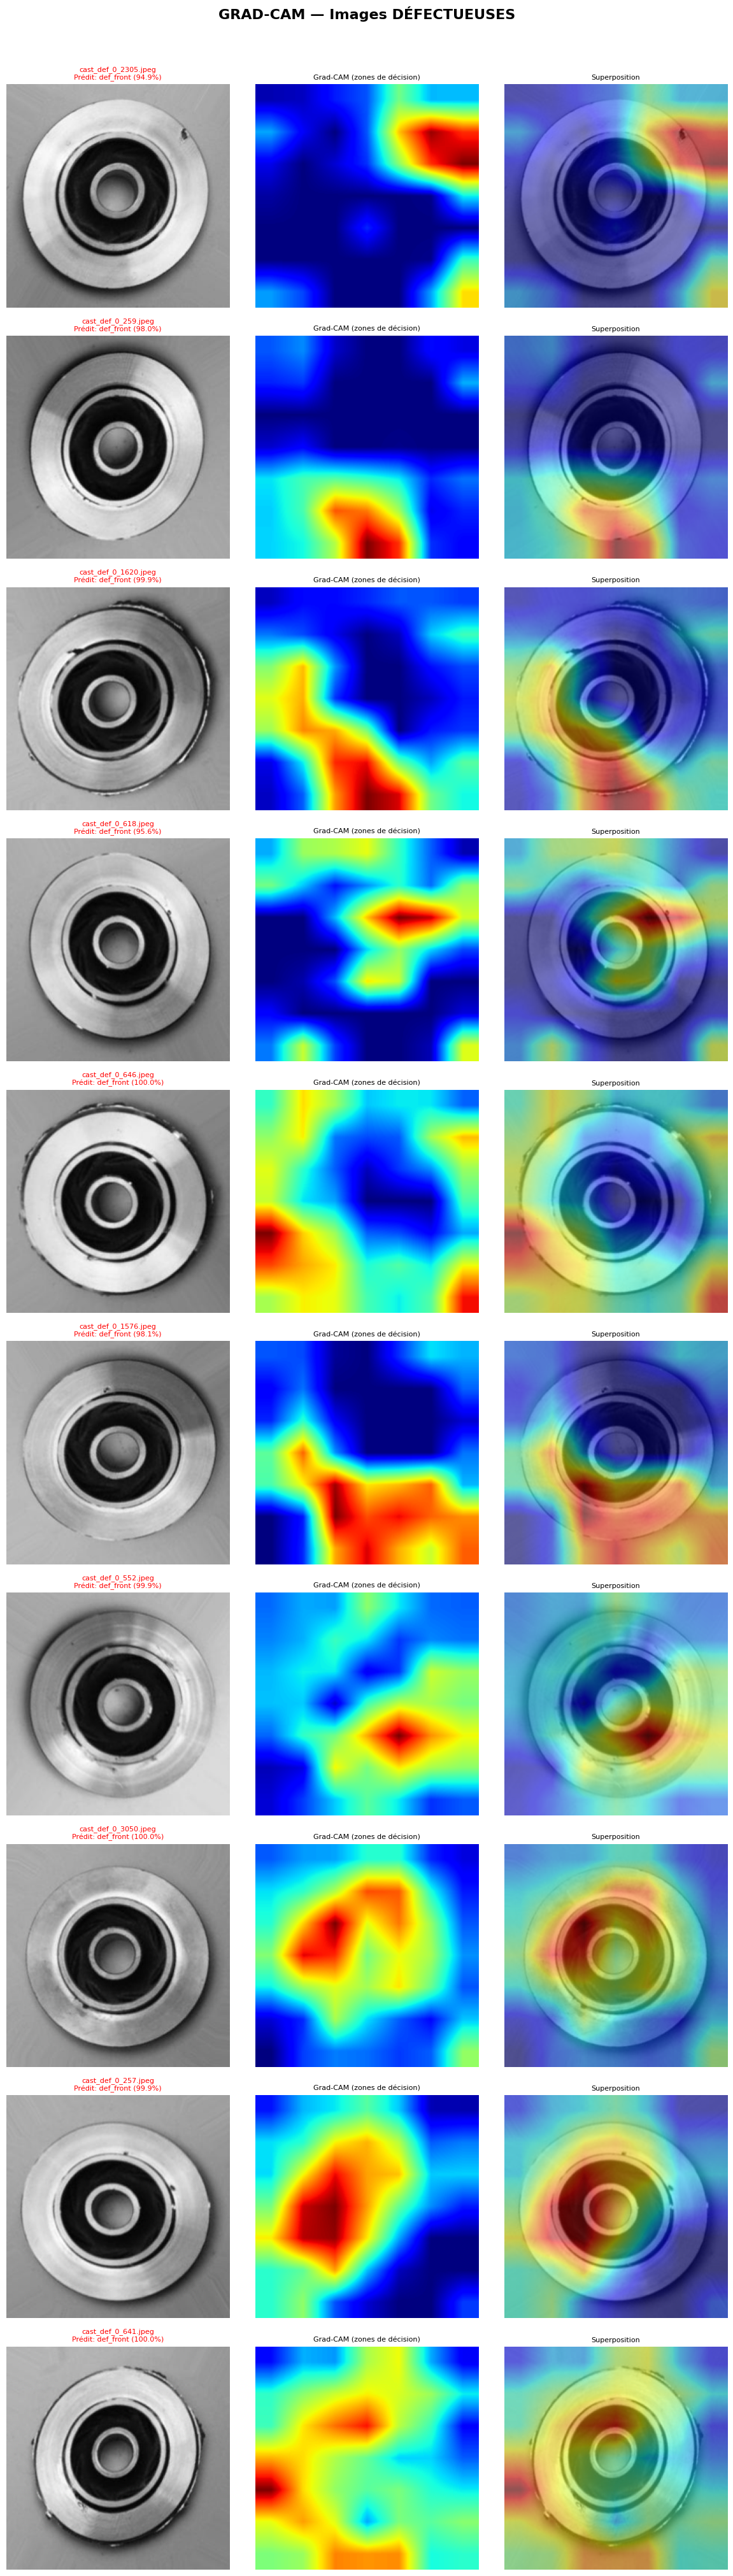

10 heatmaps de pièces défectueuses


In [14]:
# Collecter des exemples depuis le test split
np.random.seed(42)
def_test_paths = [p for p, l in zip(test_paths, test_labels) if l == 0]
ok_test_paths = [p for p, l in zip(test_paths, test_labels) if l == 1]

n_def, n_ok = 10, 5
def_samples = [def_test_paths[i] for i in np.random.choice(len(def_test_paths), min(n_def, len(def_test_paths)), replace=False)]
ok_samples = [ok_test_paths[i] for i in np.random.choice(len(ok_test_paths), min(n_ok, len(ok_test_paths)), replace=False)]

print(f'Échantillons sélectionnés: {len(def_samples)} défaut, {len(ok_samples)} OK')

# --- Heatmaps défectueuses ---
fig, axes = plt.subplots(len(def_samples), 3, figsize=(12, 4 * len(def_samples)))
fig.suptitle('GRAD-CAM — Images DÉFECTUEUSES', fontsize=16, fontweight='bold', y=1.01)

for row, img_path in enumerate(def_samples):
    show_gradcam(img_path, model, test_transform, class_names, ax_row=axes[row])

plt.tight_layout()
plt.show()
print(f'{len(def_samples)} heatmaps de pièces défectueuses')

### 6.2 Heatmaps — Images OK

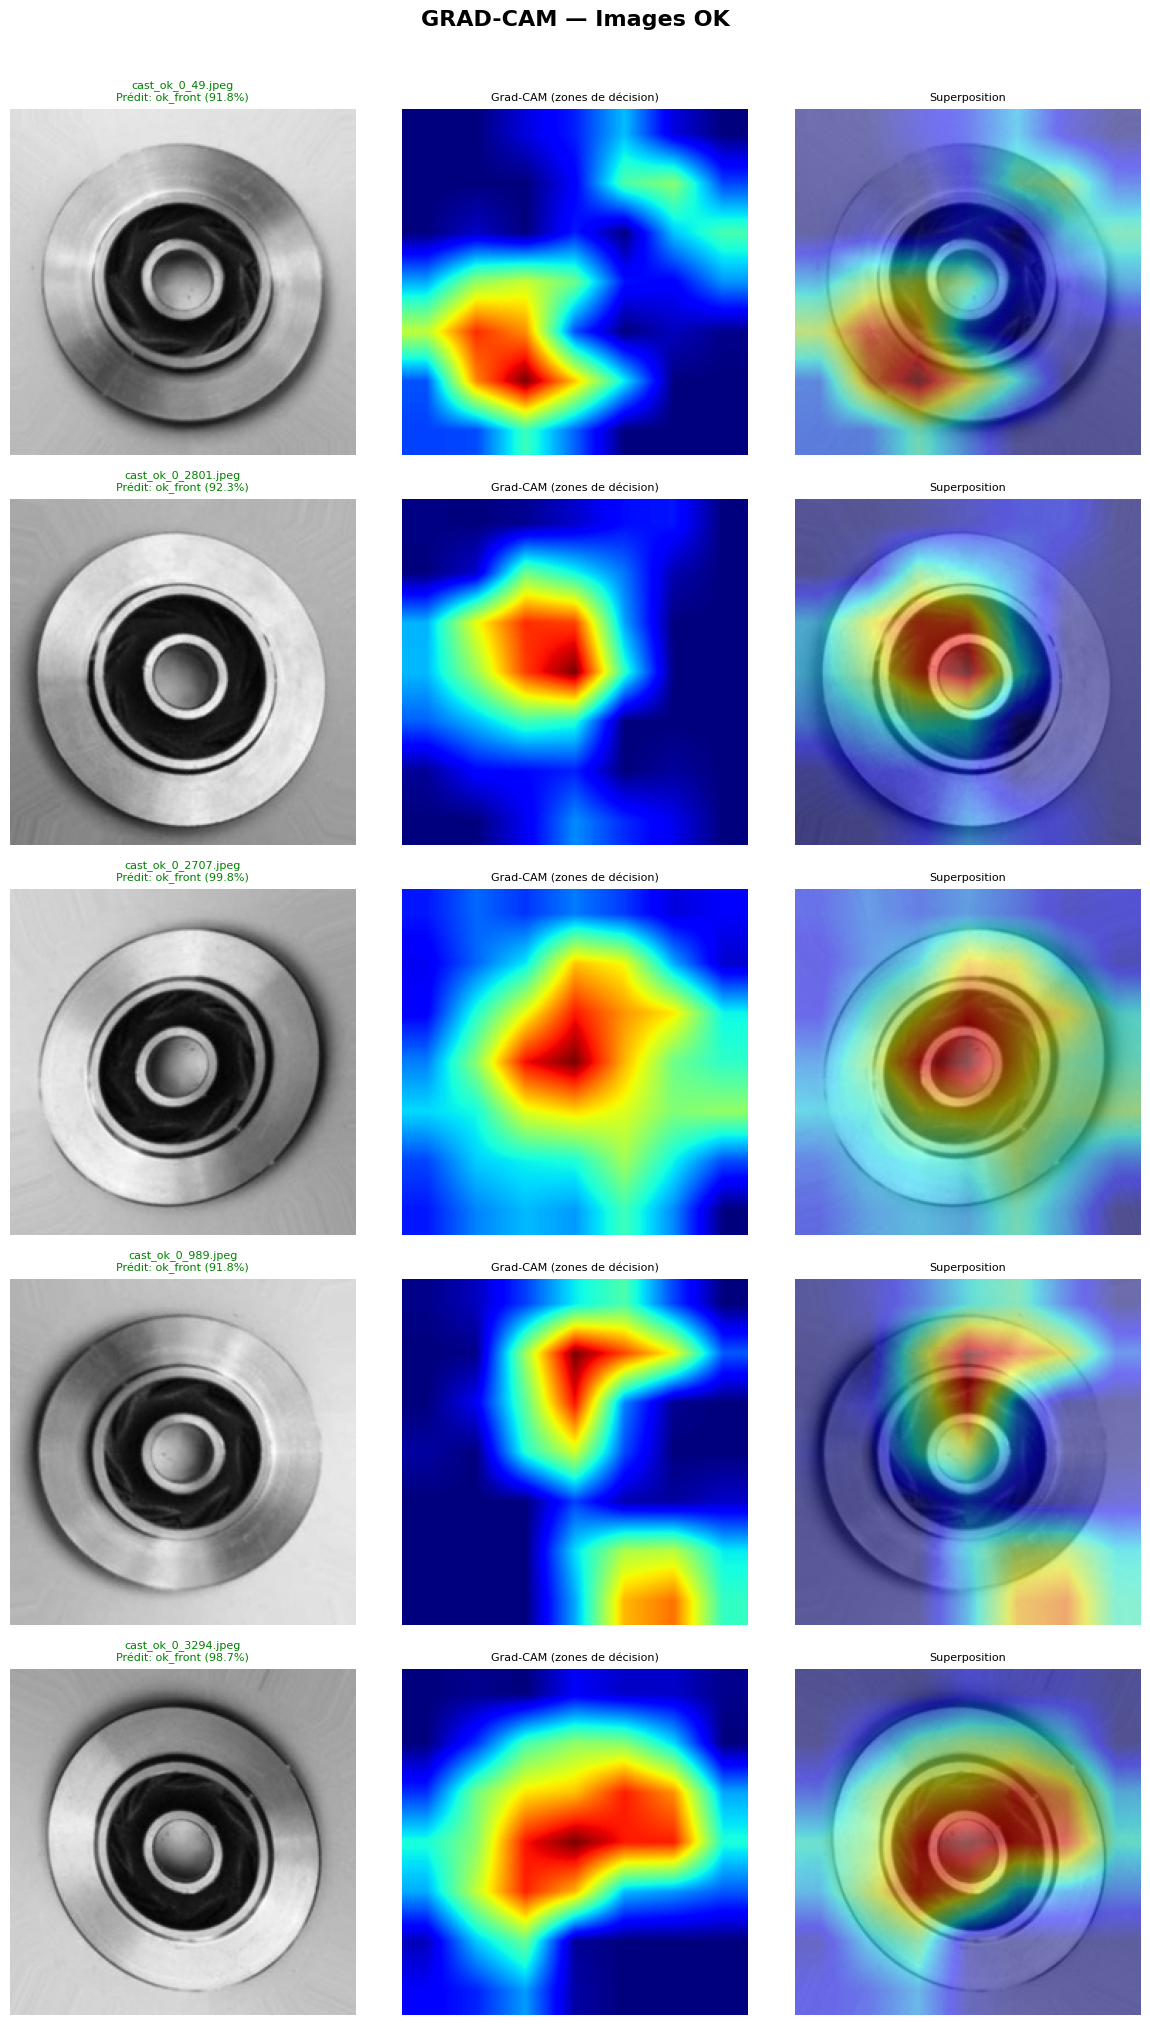

5 heatmaps de pièces OK


In [17]:
# --- Heatmaps OK ---
fig, axes = plt.subplots(len(ok_samples), 3, figsize=(12, 4 * len(ok_samples)))
fig.suptitle('GRAD-CAM — Images OK', fontsize=16, fontweight='bold', y=1.01)

for row, img_path in enumerate(ok_samples):
    show_gradcam(img_path, model, test_transform, class_names, ax_row=axes[row])

plt.tight_layout()
plt.show()
print(f'{len(ok_samples)} heatmaps de pièces OK')

### 6.3 Comparaison côte à côte : Défaut vs OK

AttributeError: 'str' object has no attribute 'name'

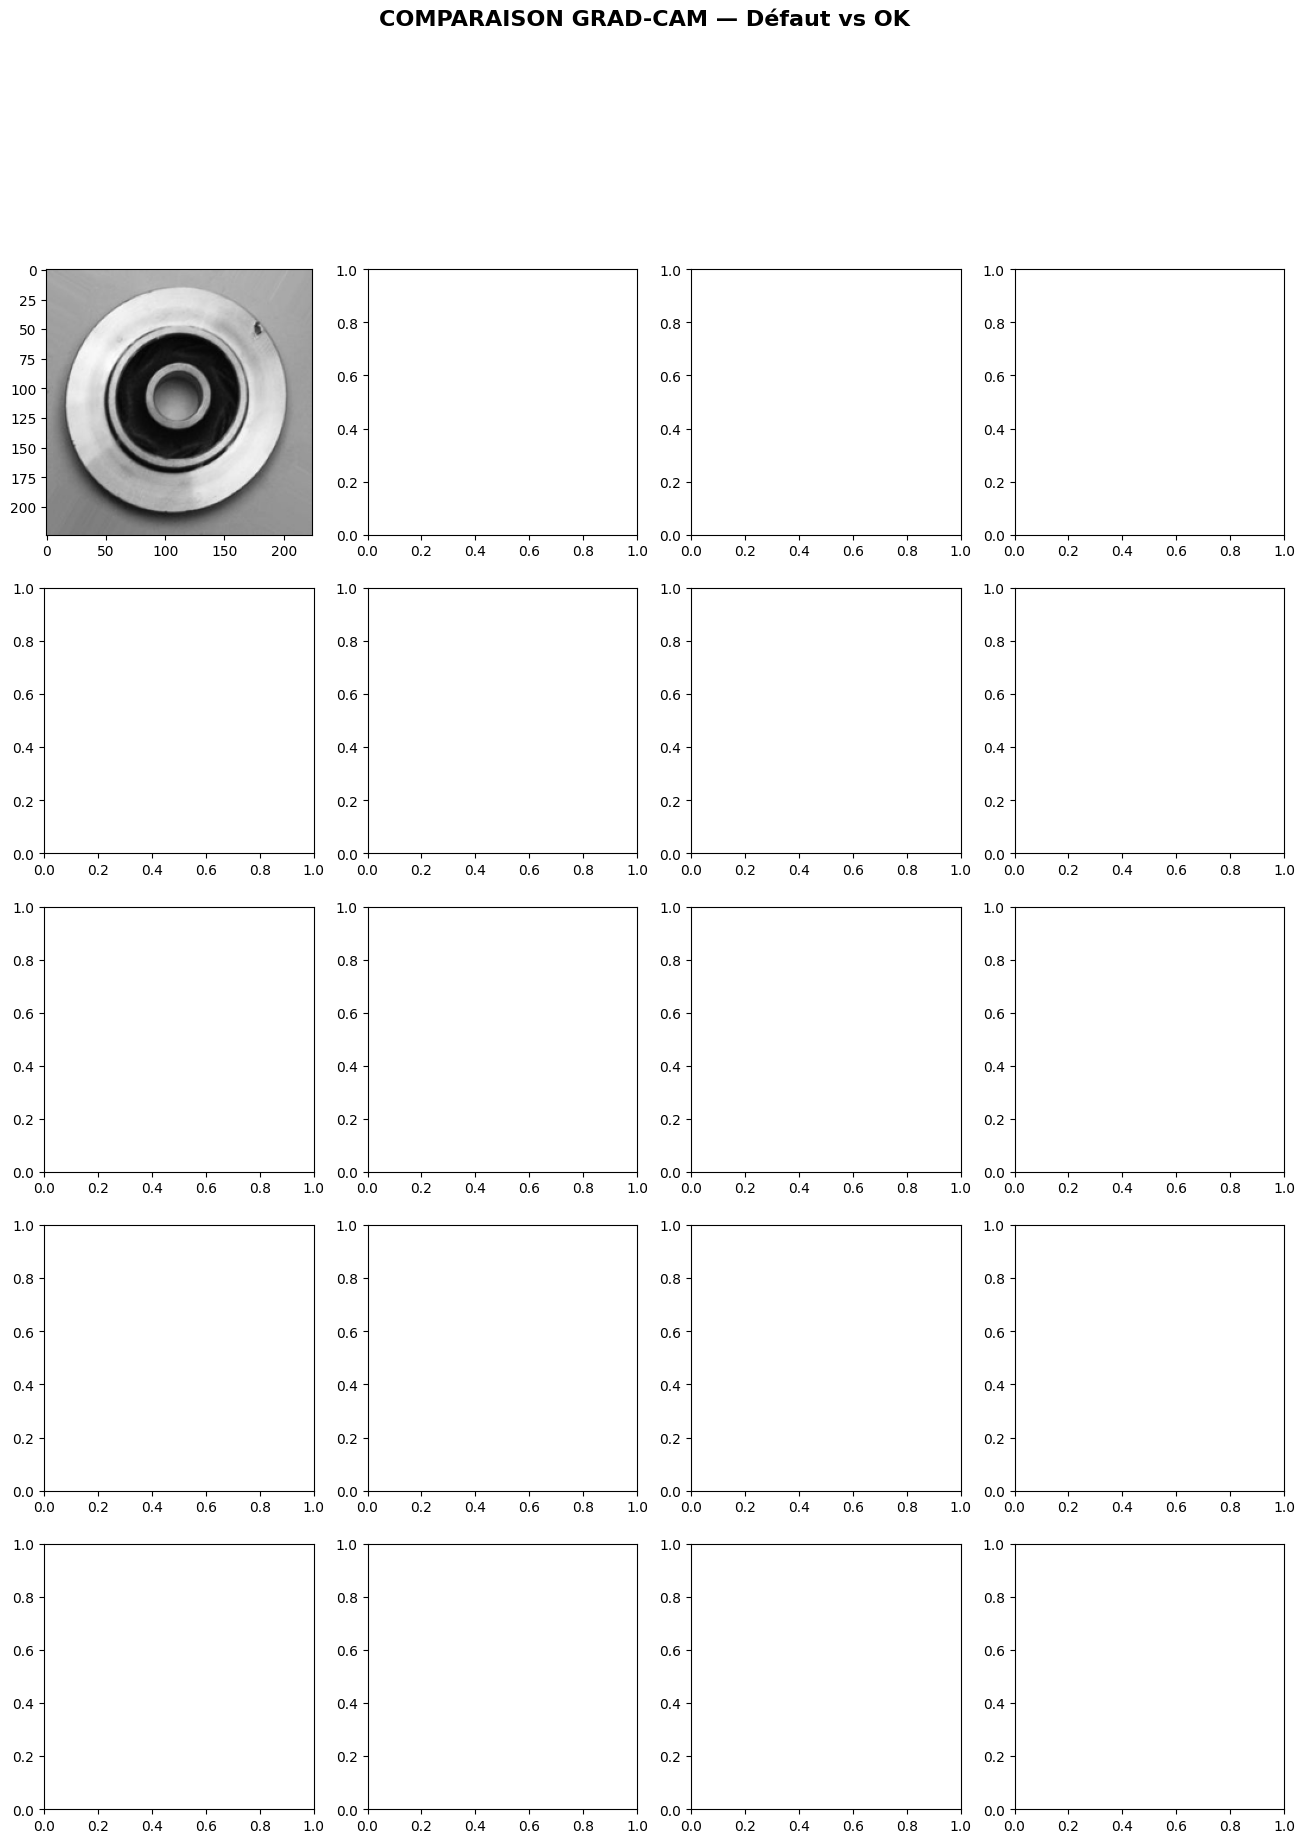

In [16]:
# --- Comparaison DEF vs OK ---
n_pairs = min(len(def_samples), len(ok_samples))
fig, axes = plt.subplots(n_pairs, 4, figsize=(16, 4 * n_pairs))
fig.suptitle('COMPARAISON GRAD-CAM — Défaut vs OK', fontsize=16, fontweight='bold', y=1.01)

for row in range(n_pairs):
    # DEF
    img_def = Image.open(def_samples[row]).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    img_def_arr = np.array(img_def)
    hmap_def, pred_def, conf_def = grad_cam(model, test_transform(img_def))
    overlay_def = np.clip(0.5 * img_def_arr / 255.0 + 0.5 * cm.jet(hmap_def)[:, :, :3], 0, 1)
    
    # OK
    img_ok = Image.open(ok_samples[row]).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    img_ok_arr = np.array(img_ok)
    hmap_ok, pred_ok, conf_ok = grad_cam(model, test_transform(img_ok))
    overlay_ok = np.clip(0.5 * img_ok_arr / 255.0 + 0.5 * cm.jet(hmap_ok)[:, :, :3], 0, 1)
    
    axes[row, 0].imshow(img_def_arr)
    axes[row, 0].set_title(f'DÉFAUT — {def_samples[row].name}', fontsize=8, color='red', fontweight='bold')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(overlay_def)
    axes[row, 1].set_title(f'Grad-CAM DEF ({class_names[pred_def]} {conf_def:.0%})', fontsize=8, color='red')
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(img_ok_arr)
    axes[row, 2].set_title(f'OK — {ok_samples[row].name}', fontsize=8, color='green', fontweight='bold')
    axes[row, 2].axis('off')
    
    axes[row, 3].imshow(overlay_ok)
    axes[row, 3].set_title(f'Grad-CAM OK ({class_names[pred_ok]} {conf_ok:.0%})', fontsize=8, color='green')
    axes[row, 3].axis('off')

plt.tight_layout()
plt.show()
print(f'{n_pairs} comparaisons DEF vs OK')